In [4]:
from tumoroscope.run_tumoroscope import run_tumoroscope
from tumoroscope.simulation import simulation as sim
from tumoroscope.visualization import visualization as vis
from tumoroscope.tumoroscope import tumoroscope as tum
from tumoroscope import constants
import pickle
import numpy as np
import random
from multiprocessing import Pool
import time
import json
import re
import pandas as pd
import glob, os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [8]:
%%time
pi_2D = True
th = 0.8 # threshhold for Z
constants.VISUALIZATION = 'visualization'
constants.CHAINS = 1
constants.CORES = 35
every_n_sample = 5
l=1
changes_batch= 500
constants.RESULTS = 'Result_demo'
number = '1'
config_file =  '../configs/simulation_demo.json'
noise = '1'


result_txt = constants.RESULTS+'/results_'
optimal_rate = 0.40
test = constants.RESULTS
begin= time.time()

if not os.path.exists(constants.RESULTS):
    os.makedirs(constants.RESULTS)
    print("Directory ", constants.RESULTS, " Created ")
else:
    print("Directory ", constants.RESULTS, " already exists")

file_name = re.split("/|.json",config_file)[2]
vis_1 = vis(constants.RESULTS + '/n_var_' + file_name + '_' + constants.VISUALIZATION)
with open(config_file) as json_data_file:
    data = json.load(json_data_file)

K = data['structure']['K']
S = data['structure']['S']
I = data['structure']['I']
theta = data['structure']['theta']

p_c_binom = data['C_variation']['p_c_binom']
C_temp = data['C_variation']['C']
repeat_temp = data['C_variation']['repeat']
if C_temp is None:
    C = None
else:
    C_t = []
    for ct in range(len(C_temp)):
        C_t.append(np.tile(C_temp[ct], (repeat_temp[ct], 1)))
    C = np.concatenate(C_t)
vis_1.heatmap_seaborn(C, 'C_seaborn', 'clones', 'mutations', False, 0.5)
sns.set_theme()
    
ax = sns.heatmap(C, annot=False, linewidths=0.5)
ax.set(xlabel='clones', ylabel='mutations')
fig = ax.get_figure()
fig.savefig(constants.RESULTS+'/C_seaborn_new' + '.png')
plt.close()

n_sampling = data['n_variation']['n_sampling']

if data['n_variation']['n'] is not None:
    n = np.array(data['n_variation']['n'])
else:
    n = None

Z = data['Z_variation']['Z']
avarage_clone_in_spot = data['Z_variation']['avarage_clone_in_spot']


max_iter = np.int(data['smapling']['max_iter'])
min_iter = np.int(data['smapling']['min_iter'])
burn_in = np.int(data['smapling']['burn_in'])
batch = np.int(data['smapling']['batch'])
var_calculation = np.int(data['smapling']['min_iter']*0.9)

phi_gamma = np.array(data['Gamma']['phi_gamma'])
        # F could be None, In that case, it will be generated using dirichlet distribution
F_epsilon = np.tile(data['Gamma']['F_epsilon'], (K, 1))
F_fraction =  data['Gamma']['F_fraction']

F = np.tile(data['Gamma']['F'], (K, 1))  # np.array([[9,2],[9,2],[9,2],[9,2],[9,2],[9,2]])
phi_gamma_selected = np.array(data['Gamma']['phi_gamma_selected'])

F_epsilon_selected = np.tile(data['Gamma']['F_epsilon_selected'], (K, 1))
F_selected = np.tile(data['Gamma']['F_selected'], (K, 1))  # np.array([[9,2],[9,2],[9,2],[9,2],[9,2],[9,2]])
gamma = data['theta']['gamma']
gamma_sampling = data['theta']['gamma_sampling']
theta_variable = data['theta']['theta_variable']

n_lambda = np.tile(data['n_variation']['n_lambda'], (S))
#while(True):
sample_1 = sim(K=K,S=S,r=phi_gamma[0],p=phi_gamma[1],I=I,F=F,D=None,A=None,C=C,avarage_clone_in_spot=avarage_clone_in_spot,random_seed=random.randint(1,100),F_epsilon= F_epsilon,n=n,p_c_binom=p_c_binom,theta=theta,Z = Z,n_lambda=n_lambda,F_fraction=F_fraction,theta_variable=theta_variable,gamma=gamma, pi_2D=pi_2D)
#    if  np.mean(np.sum(sample_1.D, axis=0)) > int(data['Gamma']['mean_read']) - 2 and np.mean(np.sum(sample_1.D, axis=0)) < int(data['Gamma']['mean_read']) + 2:
#        break
#print('reads average: '+str(np.mean(np.sum(sample_1.D, axis=0))))
if noise=='0':
    n_lambda_tum = sample_1.n
else:
    b = np.random.binomial(n=1,p=0.5,size=S)
    noise_pois = np.random.poisson(lam=int(noise),size=S)
    n_lambda_tum = sample_1.n+noise_pois*b+noise_pois*(b-1)
    n_lambda_tum[n_lambda_tum<1]=1

vis_1.visualizing_simulated_data(sample_1)
pickle.dump(sample_1, open(constants.RESULTS+'/sample_1_'+file_name, 'wb'))

tum_obj=(tum(name = constants.RESULTS +'/'+ file_name+'_chain_'+str(constants.CHAINS),K=sample_1.K,S=sample_1.S,r=phi_gamma_selected[0],p=phi_gamma_selected[1],I=sample_1.I,avarage_clone_in_spot=sample_1.avarage_clone_in_spot,F = F_selected,C = sample_1.C,A = sample_1.A,D = sample_1.D,F_epsilon=F_epsilon_selected,optimal_rate=optimal_rate,n_lambda = n_lambda_tum,gamma = gamma_sampling, pi_2D=pi_2D,result_txt=result_txt+file_name+'.txt'))
tum_obj.gibbs_sampling(seed = random.randint(1,100) ,min_iter=min_iter,max_iter = max_iter,burn_in=burn_in, batch = batch,simulated_data= sample_1,n_sampling=True,F_fraction=F_fraction,theta_variable = theta_variable, pi_2D=pi_2D,th=th,every_n_sample=every_n_sample,changes_batch=changes_batch,var_calculation=var_calculation)
pickle.dump(tum_obj, open(constants.RESULTS+'/tum_all_'+file_name, 'wb'))


Directory  Result_demo  Created 
Directory  Result_demo/n_var_simulation_demo_visualization  Created 


<timed exec>:66: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<timed exec>:67: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

simulation finished
simulation finished
Batch 0 finished with [61.67 74.17 44.17 43.33 49.17 50.  ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 1 finished with [85.83 61.67 45.83 48.33 50.   46.67]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 2 finished with [89.17 53.33 59.17 55.83 59.17 46.67]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 3 finished with [90.   48.33 53.33 53.33 55.83 62.5 ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 4 finished with [90.   45.83 53.33 45.83 53.33 51.67]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 5 finished with [90.   50.   45.83 60.   55.   64.17]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 6 finished with [90.83 54.17 51.67 54.17 65.   53.33]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 7 finished with [90.83 55.   64.17 54.17 58.33 58.33]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 8 finished with [93.33 56.67 57.5  67.5  63.33 60.83]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 

Text(0.5, 1.0, 'Mean Average Error (MAE): 0.0071')

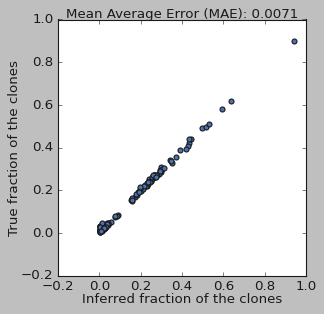

In [9]:
mpl.style.use('classic')
font_size=12
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(tum_obj.inferred_H.tolist(),sample_1.H.tolist())
ax.set_ylabel('True fraction of the clones', fontsize=font_size,labelpad=0.05)
ax.set_xlabel('Inferred fraction of the clones', fontsize=font_size,labelpad=0.05)
ax.set_title('Mean Average Error (MAE): '+str(round(tum_obj.H_SEE,4)),fontsize=font_size, pad = 1.5)